In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from google.colab import drive, files

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# point to the drive directory
endo_dir = '/content/drive/MyDrive/endometriosis/'

In [ ]:
dataset_file = os.path.join(endo_dir, 'data','endo+endometriosis.pkl')
data_df = pd.read_pickle(dataset_file).drop(columns=['url', 'parent_id', 'flair', 'created_utc'])
print(len(data_df))
data_df[:1]

392087


,author,id,type,text,link_id,subreddit,time
0,endogirl,Endo_c3efp47_comment,comment,Soy is a no go as it increases estrogen in you...,t3_mrkjh,Endo,2012-01-06 06:44:29


In [ ]:
#Load topic modeling file
topic_model_file = os.path.join(endo_dir, 'output', 'topic-modeling', 'parags', 'endo+endometriosis-25_10.pkl')
tomo_df = pd.read_pickle(topic_model_file).reset_index().rename(columns = {"index":"id"}).drop('og_doc', axis=1) # change index into column

In [ ]:
zscores = tomo_df.copy()
cols = list(zscores.columns[1:26])
# get z scores for each topic column
for col in cols:
  zscores[col] = stats.zscore(zscores[col])

tomo_df = zscores
tomo_df[:1]

,id,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,...,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,dominant_topic
0,Endo_c3efp47_comment_0,-0.196283,-0.283443,-0.298325,-0.207986,-0.269278,-0.301317,-0.243336,-0.418346,-0.267528,...,0.303848,-0.259111,-0.285519,3.848055,-0.363482,-0.303682,-0.183964,-0.242979,2.277669,19


In [ ]:
# add column with info about where the paragraph comes from, whether post or comment
tomo_df['og_id'] = ['_'.join(x.split('_')[:3]) for x in tomo_df.id]

# group paragraphs' distributions by the post/comment the paragraph comes from, taking the average of the distributions
new_tomo_df = tomo_df.groupby(['og_id'], sort=False).mean().reset_index().rename(columns = {"og_id":"id"})
print(len(new_tomo_df))
new_tomo_df[:1]

334042


,id,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,...,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,dominant_topic
0,Endo_c3efp47_comment,-0.196283,-0.283443,-0.298325,-0.207986,-0.269278,-0.301317,-0.243336,-0.418346,-0.267528,...,0.303848,-0.259111,-0.285519,3.848055,-0.363482,-0.303682,-0.183964,-0.242979,2.277669,19.0


In [ ]:
# Merge dataset with topic modeling distributions
big_df = pd.merge(data_df, new_tomo_df, how = "left", left_on = "id", right_on = "id").dropna()
print('Length df after merge:', len(big_df))
big_df[:1]

Length df after merge: 334068


,author,id,type,text,link_id,subreddit,time,Topic 0,Topic 1,Topic 2,...,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,dominant_topic
0,endogirl,Endo_c3efp47_comment,comment,Soy is a no go as it increases estrogen in you...,t3_mrkjh,Endo,2012-01-06 06:44:29,-0.196283,-0.283443,-0.298325,...,0.303848,-0.259111,-0.285519,3.848055,-0.363482,-0.303682,-0.183964,-0.242979,2.277669,19.0


In [ ]:
# remove any dupes from merging
dupes = big_df.id.duplicated()
dupes_idx = dupes.loc[dupes == True].index
print('Number of dupes', len(dupes_idx))
big_df = big_df.drop(dupes_idx).reset_index().drop(columns=['index'])
print('Length df after removing dupes', len(big_df))
big_df[:1]

Number of dupes 26
Length df after removing dupes 334042


,author,id,type,text,link_id,subreddit,time,Topic 0,Topic 1,Topic 2,...,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,dominant_topic
0,endogirl,Endo_c3efp47_comment,comment,Soy is a no go as it increases estrogen in you...,t3_mrkjh,Endo,2012-01-06 06:44:29,-0.196283,-0.283443,-0.298325,...,0.303848,-0.259111,-0.285519,3.848055,-0.363482,-0.303682,-0.183964,-0.242979,2.277669,19.0


In [ ]:
# selecting only posts
posts_df = big_df.loc[big_df['type'] == 'post'].copy()

# adding a column with reddit og identifier to merge later
posts_df['link_id'] = ['t3_'+x.split('_')[1] for x in posts_df.id]
print(len(posts_df))
posts_df[:1]

34190


,author,id,type,text,link_id,subreddit,time,Topic 0,Topic 1,Topic 2,...,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,dominant_topic
6,theonusta,Endo_otb0m_post,post,We've been a community of Endometriosis suppor...,t3_otb0m,Endo,2012-01-23 20:14:29,-0.205552,-0.298024,0.329341,...,2.531225,-0.271936,-0.298816,-0.224973,-0.176872,-0.318968,-0.192726,-0.254702,-0.313315,12.0


In [ ]:
# dataframe with comments' topic distributions grouped by post they are responding to
comm_distrib = big_df.loc[big_df['type'] == 'comment'].drop(columns=['dominant_topic']).groupby(['link_id'], sort=False).mean()
rename_d = {}
for col in comm_distrib.columns:
  rename_d[col] = f'{col} comments'
comm_distrib.rename(columns=rename_d, inplace=True)

In [ ]:
# merging comments' distributions with posts distributions
posts_comm = pd.merge(posts_df, comm_distrib, how = "left", left_on = "link_id", right_on = "link_id").dropna()
print('Length df after merge:', len(posts_comm))
posts_comm[:1]

Length df after merge: 29949


,author,id,type,text,link_id,subreddit,time,Topic 0,Topic 1,Topic 2,...,Topic 15 comments,Topic 16 comments,Topic 17 comments,Topic 18 comments,Topic 19 comments,Topic 20 comments,Topic 21 comments,Topic 22 comments,Topic 23 comments,Topic 24 comments
0,theonusta,Endo_otb0m_post,post,We've been a community of Endometriosis suppor...,t3_otb0m,Endo,2012-01-23 20:14:29,-0.205552,-0.298024,0.329341,...,0.624547,-0.087669,0.434948,0.050264,0.876492,0.010314,0.302331,-0.168074,-0.054633,0.065927


### Correlations between topics in the posts and topics in the comments

In [ ]:
topics_corr = posts_comm.drop(columns=['author', 'id', 'type', 'text', 'link_id', 'subreddit', 'time', 'dominant_topic']).corr()
to_drop = topics_corr.columns[0:25]
topic_corr = topics_corr[0:25].drop(columns=to_drop)
topic_corr[:3]

,Topic 0 comments,Topic 1 comments,Topic 2 comments,Topic 3 comments,Topic 4 comments,Topic 5 comments,Topic 6 comments,Topic 7 comments,Topic 8 comments,Topic 9 comments,...,Topic 15 comments,Topic 16 comments,Topic 17 comments,Topic 18 comments,Topic 19 comments,Topic 20 comments,Topic 21 comments,Topic 22 comments,Topic 23 comments,Topic 24 comments
Topic 0,0.379575,-0.018128,-0.025799,-0.013070,0.026928,-0.011146,-0.028811,-0.037967,0.032294,-0.030547,...,0.014518,-0.055960,-0.022390,-0.038214,0.103901,-0.017955,0.028890,-0.003613,0.004855,-0.036937
Topic 1,0.009668,0.356878,0.014929,-0.003486,-0.038211,-0.033079,-0.023979,-0.064881,0.158985,-0.047107,...,-0.006328,-0.047326,-0.026927,-0.044102,-0.043698,0.043892,-0.037179,0.008800,-0.048547,-0.052944
Topic 2,-0.038342,0.080797,0.365563,-0.034009,0.046441,-0.029840,-0.003344,-0.045498,-0.022220,0.023330,...,-0.077663,-0.060129,-0.006625,-0.053918,-0.051324,0.005414,-0.045750,-0.042895,-0.058916,-0.008367


In [ ]:
topics_names_list = ["Topic 0: gastrointestinal", 
    "Topic 3: pelvic floor",
    "Topic 5: menstruation",
    "Topic 17: muscular ",
    "Topic 21: sharing symptoms",
    "Topic 14: pain management",
    "Topic 23: drugs",
    "Topic 18: hormonal drug experiences",
    "Topic 24: info on hormonal drugs",
    "Topic 1: info on diagnostic surgery",
    "Topic 2: medical information",
    "Topic 4: getting diagnosed",
    "Topic 6: online resources",
    "Topic 9: specialists",
    "Topic 13: insurance",
    "Topic 20: medical appointments",
    "Topic 8: post surgery recovery",
    "Topic 15: product recommendations",
    "Topic 19: diet",
    "Topic 22: comfort items",
    "Topic 7: dismissal and abuse",
    "Topic 10: gratitude",
    "Topic 11: medical story",
    "Topic 12: fertility",
    "Topic 16: empathy",
    ]
topics_names_d = {}
for topic_name in topics_names_list:
  topics_names_d[topic_name.split(":")[0]] = topic_name

In [ ]:
# changing order of the rows
re_topic_corr = topic_corr.reindex(topics_names_d.keys())
re_topic_corr['topics_names'] = topics_names_d.values()
re_topic_corr.set_index('topics_names', inplace=True)

In [ ]:
# changing order of the columns
topics_names_d_comm = {}
for key, value in topics_names_d.items():
  topics_names_d_comm[f'{key} comments'] = f'{value} comments'
re_topic_corr = re_topic_corr.rename(columns=topics_names_d_comm)
re_topic_corr = re_topic_corr[topics_names_d_comm.values()]

In [ ]:
re_topic_corr[:5]

,Topic 0: gastrointestinal comments,Topic 3: pelvic floor comments,Topic 5: menstruation comments,Topic 17: muscular comments,Topic 21: sharing symptoms comments,Topic 14: pain management comments,Topic 23: drugs comments,Topic 18: hormonal drug experiences comments,Topic 24: medical info on hormonal drugs comments,Topic 2: medical information comments,...,Topic 1: pre and post surgery comments,Topic 8: post surgery recovery comments,Topic 15: product recommendations comments,Topic 19: diet comments,Topic 22: comfort items comments,Topic 7: dismissal and abuse comments,Topic 10: gratitude comments,Topic 11: medical story comments,Topic 12: fertility comments,Topic 16: empathy comments
topics_names,,,,,,,,,,,,,,,,,,,,,
Topic 0: gastrointestinal,0.379575,-0.013070,-0.011146,-0.022390,0.028890,0.008313,0.004855,-0.038214,-0.036937,-0.025799,...,-0.018128,0.032294,0.014518,0.103901,-0.003613,-0.037967,-0.020839,-0.029278,-0.051492,-0.055960
Topic 3: pelvic floor,-0.016663,0.277835,-0.041377,0.064994,-0.011570,0.017092,-0.002669,-0.032787,-0.019164,-0.038652,...,-0.012833,-0.011214,0.006814,-0.011744,-0.011142,0.001550,-0.009721,-0.017185,-0.032224,0.014852
Topic 5: menstruation,-0.017923,-0.015038,0.377046,0.005035,0.026584,-0.069438,-0.039714,0.098635,0.011602,0.016954,...,-0.052353,-0.091122,-0.071439,-0.039493,-0.023049,-0.027700,-0.050284,0.035866,-0.028837,-0.088590
Topic 17: muscular,-0.018499,0.168816,0.006740,0.463591,0.082135,-0.036644,-0.063716,-0.065528,-0.076812,0.043948,...,-0.020881,-0.015535,0.020387,-0.043742,-0.013674,-0.029673,-0.046725,-0.006603,-0.071157,-0.060847
Topic 21: sharing symptoms,0.105512,0.000737,0.030052,0.062469,0.266582,0.049735,-0.021259,-0.039863,-0.072293,-0.048630,...,-0.061030,-0.007133,0.039455,0.037079,-0.027682,0.016613,-0.002722,-0.015180,-0.076694,0.009384


In [ ]:
pd.Series(np.diag(re_topic_corr), index=re_topic_corr.index).sort_values(ascending=False).to_csv('boh.csv')

In [ ]:
re_topic_corr2 = re_topic_corr.copy()
np.fill_diagonal(re_topic_corr2.values, None)
re_topic_corr2

,Topic 0: gastrointestinal comments,Topic 3: pelvic floor comments,Topic 5: menstruation comments,Topic 17: muscular comments,Topic 21: sharing symptoms comments,Topic 14: pain management comments,Topic 23: drugs comments,Topic 18: hormonal drug experiences comments,Topic 24: medical info on hormonal drugs comments,Topic 2: medical information comments,...,Topic 1: pre and post surgery comments,Topic 8: post surgery recovery comments,Topic 15: product recommendations comments,Topic 19: diet comments,Topic 22: comfort items comments,Topic 7: dismissal and abuse comments,Topic 10: gratitude comments,Topic 11: medical story comments,Topic 12: fertility comments,Topic 16: empathy comments
topics_names,,,,,,,,,,,,,,,,,,,,,
Topic 0: gastrointestinal,NaN,-0.013070,-0.011146,-0.022390,0.028890,0.008313,0.004855,-0.038214,-0.036937,-0.025799,...,-0.018128,0.032294,0.014518,0.103901,-0.003613,-0.037967,-0.020839,-0.029278,-0.051492,-0.055960
Topic 3: pelvic floor,-0.016663,NaN,-0.041377,0.064994,-0.011570,0.017092,-0.002669,-0.032787,-0.019164,-0.038652,...,-0.012833,-0.011214,0.006814,-0.011744,-0.011142,0.001550,-0.009721,-0.017185,-0.032224,0.014852
Topic 5: menstruation,-0.017923,-0.015038,NaN,0.005035,0.026584,-0.069438,-0.039714,0.098635,0.011602,0.016954,...,-0.052353,-0.091122,-0.071439,-0.039493,-0.023049,-0.027700,-0.050284,0.035866,-0.028837,-0.088590
Topic 17: muscular,-0.018499,0.168816,0.006740,NaN,0.082135,-0.036644,-0.063716,-0.065528,-0.076812,0.043948,...,-0.020881,-0.015535,0.020387,-0.043742,-0.013674,-0.029673,-0.046725,-0.006603,-0.071157,-0.060847
Topic 21: sharing symptoms,0.105512,0.000737,0.030052,0.062469,NaN,0.049735,-0.021259,-0.039863,-0.072293,-0.048630,...,-0.061030,-0.007133,0.039455,0.037079,-0.027682,0.016613,-0.002722,-0.015180,-0.076694,0.009384
Topic 14: pain management,0.001440,-0.013875,-0.059718,-0.038830,0.004071,NaN,0.049162,-0.050804,-0.031474,-0.088132,...,-0.035458,0.015782,0.079967,0.008977,-0.016353,0.007979,-0.027252,-0.058397,-0.050727,0.037010
Topic 23: drugs,0.009449,-0.020503,-0.016312,-0.053887,-0.012830,0.050557,NaN,0.102074,0.123754,-0.074925,...,-0.053135,-0.048030,-0.007655,0.008680,-0.016942,-0.038097,-0.033025,-0.046520,-0.038463,-0.045251
Topic 18: hormonal drug experiences,-0.046557,-0.030905,0.062380,-0.067095,-0.030213,-0.048311,0.133987,NaN,0.183470,-0.056729,...,-0.044729,-0.070787,-0.065812,-0.034805,-0.040081,-0.052692,-0.036694,-0.039412,-0.011382,-0.070981
Topic 24: medical info on hormonal drugs,-0.048111,-0.021483,-0.021938,-0.060253,-0.060184,-0.016058,0.135662,0.135769,NaN,-0.015147,...,-0.028988,-0.065814,-0.051165,0.009170,-0.036446,-0.035518,-0.053213,-0.028875,0.044568,-0.043439


In [ ]:
d = {'Post':[], 'Comment':[], 'Value':[]}
for index,row in re_topic_corr2.iterrows():
  idx = 0
  for col in re_topic_corr2.columns:
    d['Post'].append(index)
    d['Comment'].append(col)
    d['Value'].append(row[idx])
    idx += 1
ddf = pd.DataFrame(d)
ddf.sort_values('Value', ascending=False)[:10].to_csv('now.csv')

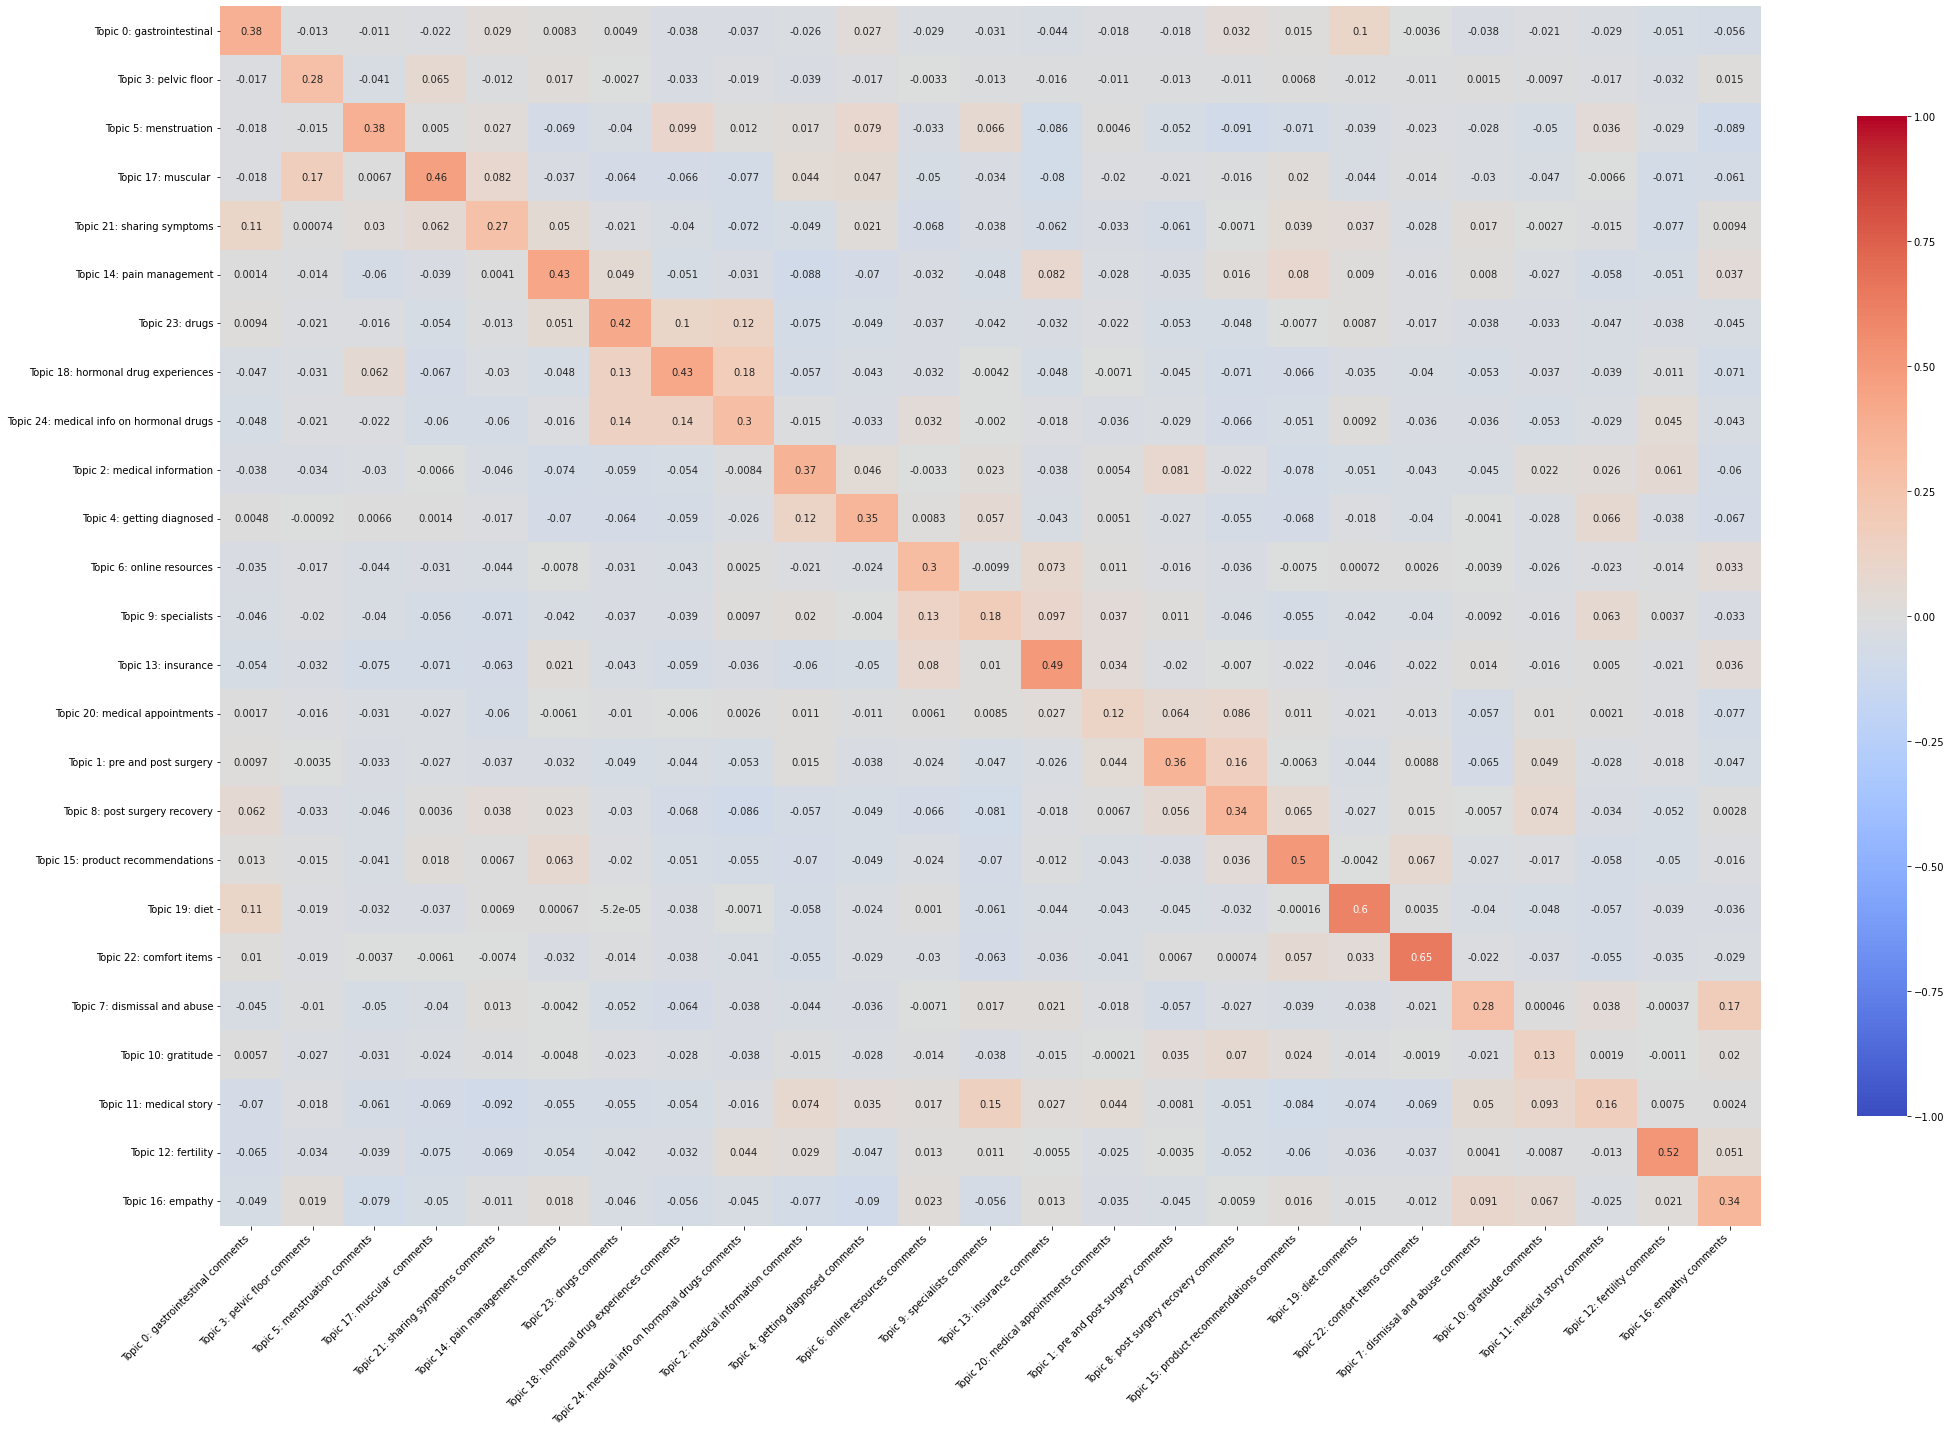

In [ ]:
plt.figure(figsize=(30, 20))
cmap = sns.color_palette("coolwarm", as_cmap=True)
heatmap = sns.heatmap(re_topic_corr, vmin=-1, vmax=1, center=0, annot=True, cmap=cmap, cbar_kws={"shrink": .82})
plt.yticks(rotation=360, ha='right')
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.savefig(os.path.join(endo_dir, 'output', 'figures', 'Topics_Correlations', 'general_zscores.png'), dpi = 300)

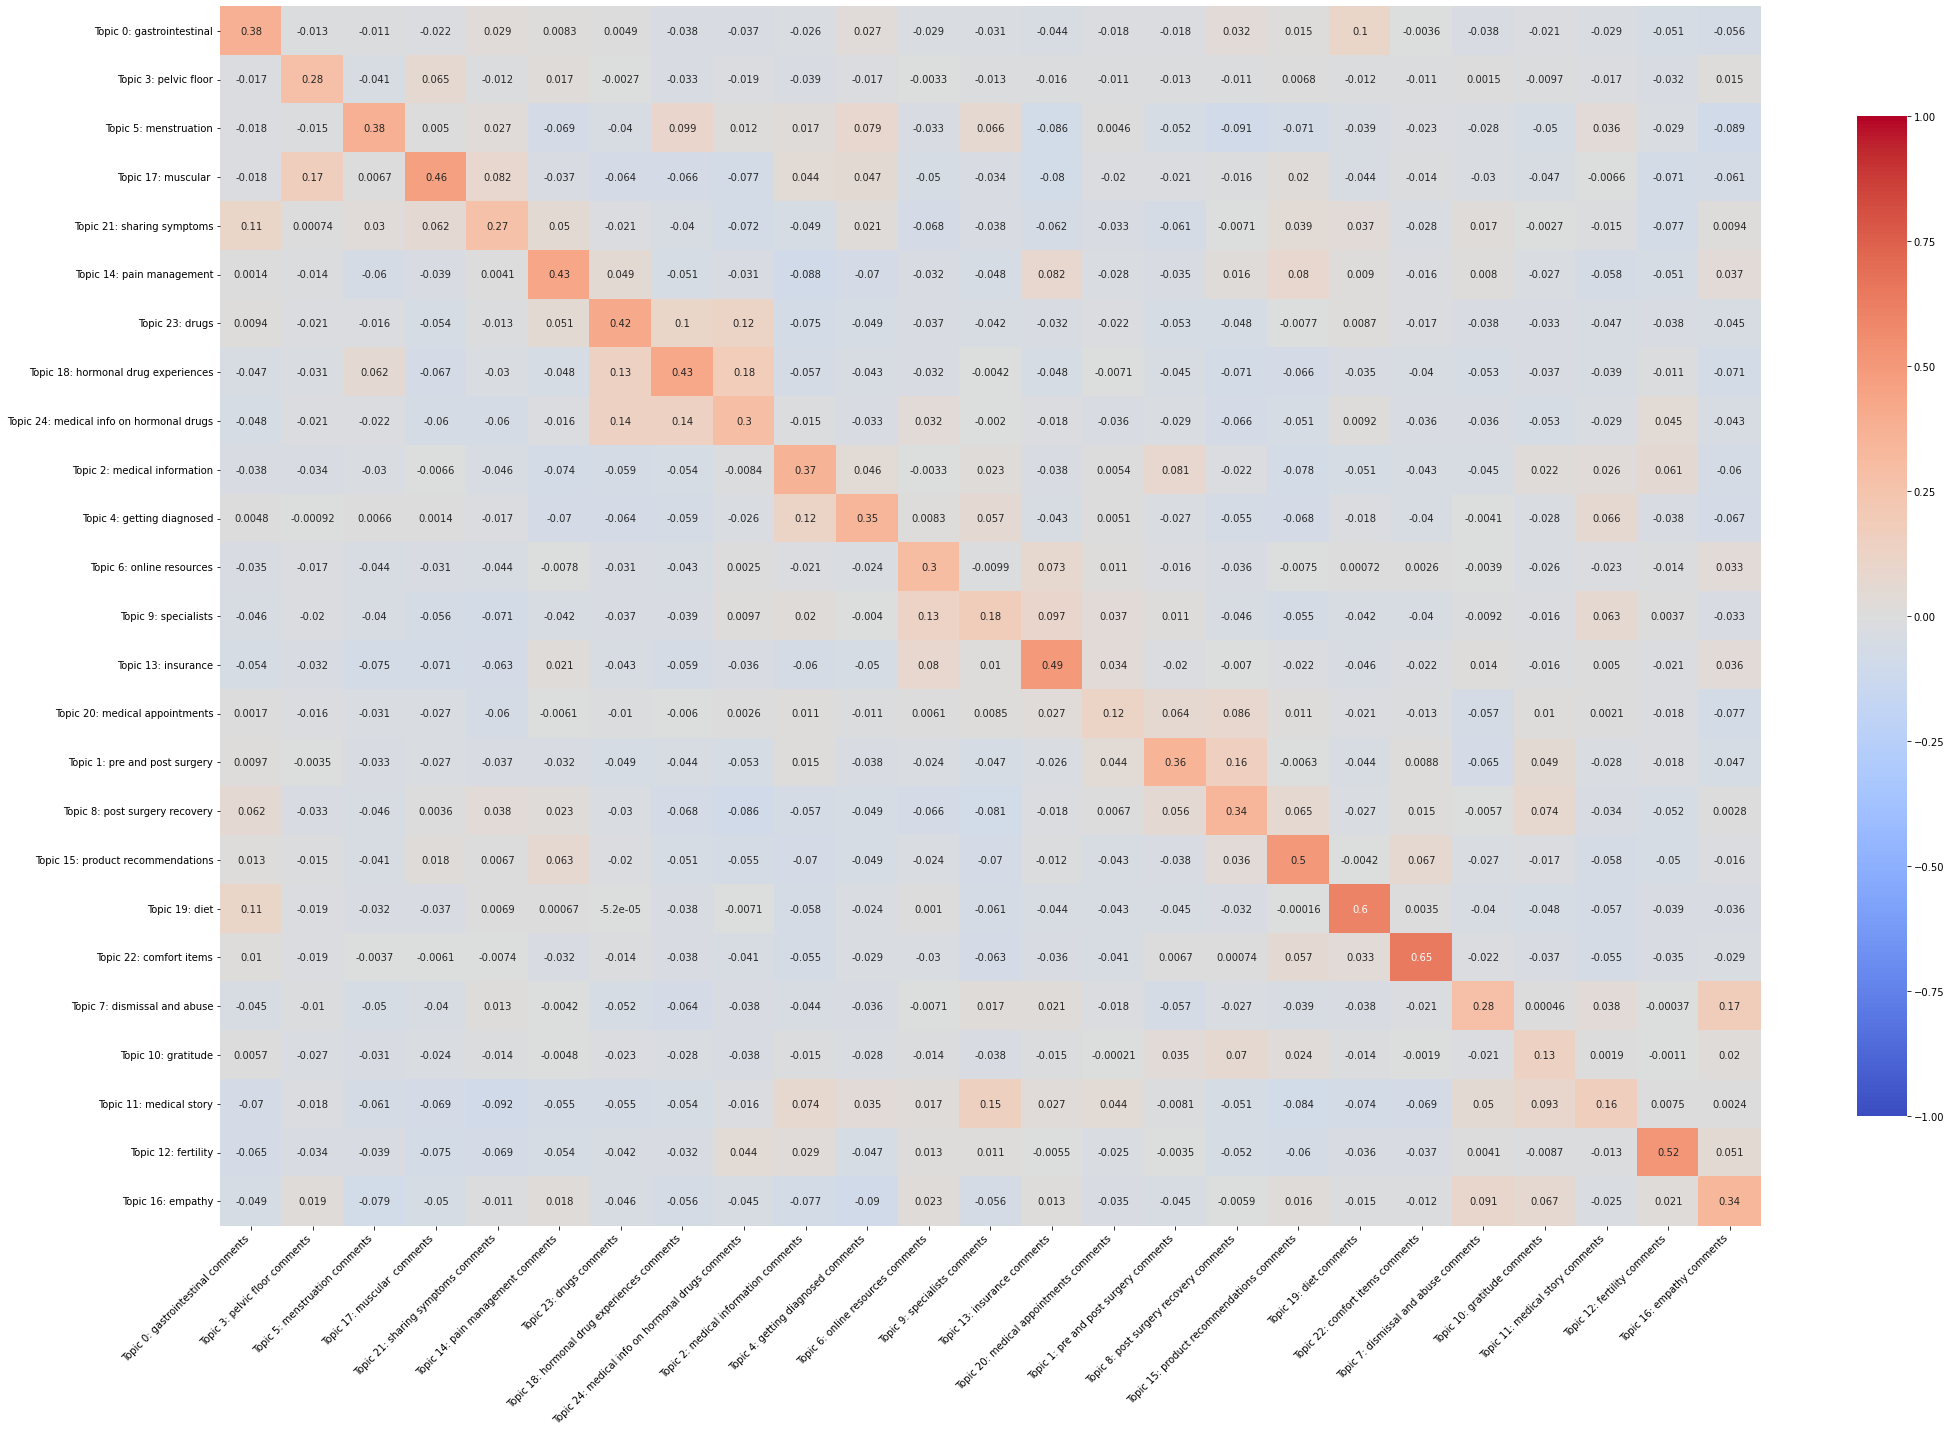

In [ ]:
plt.figure(figsize=(30, 20))
cmap = sns.color_palette("coolwarm", as_cmap=True)
heatmap = sns.heatmap(re_topic_corr, vmin=-1, vmax=1, center=0, annot=True, cmap=cmap, cbar_kws={"shrink": .82})
plt.yticks(rotation=360, ha='right')
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.savefig(os.path.join(endo_dir, 'output', 'figures', 'Topics_Correlations', 'general.png'), dpi = 300)

### Correlations with intent

In [ ]:
intent_file = os.path.join(endo_dir, 'output', 'predictions', 'INTENT', 'intent_predictions.pkl')
intent = pd.read_pickle(intent_file)
print(len(intent))
intent[:1]

In [ ]:
posts_comm_personas = posts_comm.merge(intent[['id', 'predictions_SEEKING EXPERIENCES', 'predictions_SEEKING INFO']], how = "right", left_on = "id", right_on = "id").dropna()
print(len(posts_comm_personas))
posts_comm_personas[:1]

In [ ]:
info_posts_comm = posts_comm_personas[posts_comm_personas['predictions_SEEKING EXPERIENCES'] > 0]
exp_posts_comm = posts_comm_personas[posts_comm_personas['predictions_SEEKING INFO'] > 0]

In [ ]:
info_topics_corr = info_posts_comm.drop(columns=['author', 'id', 'type', 'text', 'link_id', 'subreddit', 'time', 'dominant_topic']).corr()
to_drop = info_topics_corr.columns[0:25].tolist()
to_drop.extend(info_topics_corr.columns[-2:])
info_topics_corr = info_topics_corr[0:25].drop(columns=to_drop)

In [ ]:
plt.figure(figsize=(25, 10))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
heatmap = sns.heatmap(info_topics_corr, vmin=-.5, vmax=.5, annot=True, cmap=cmap)
#plt.savefig(os.path.join(chronic_conditions_dir, 'results', 'heatmap_fig'), dpi = 300)

In [ ]:
exp_topics_corr = exp_posts_comm.drop(columns=['author', 'id', 'type', 'text', 'link_id', 'subreddit', 'time', 'dominant_topic']).corr()
to_drop = exp_topics_corr.columns[0:25].tolist()
to_drop.extend(exp_topics_corr.columns[-2:])
exp_topics_corr = exp_topics_corr[0:25].drop(columns=to_drop)

In [ ]:
plt.figure(figsize=(25, 10))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
heatmap = sns.heatmap(exp_topics_corr, vmin=-.5, vmax=.5, annot=True, cmap=cmap)
#plt.savefig(os.path.join(chronic_conditions_dir, 'results', 'heatmap_fig'), dpi = 300)

### Correlations with personas

In [ ]:
# load file with personas predictions
personas_file = os.path.join(endo_dir, 'output', 'predictions', 'PERSONAS', 'personas_predictions.pkl')
personas = pd.read_pickle(personas_file)

# group by where the paragraph is from
personas['og_id'] = [x.split('_')[0]+'_'+x.split('_')[1]+'_'+x.split('_')[2] for x in personas.id]

#select only those in from posts
personas_posts = personas.loc[personas['type'] == 'post']

#group by post id
personas_posts = personas_posts.groupby(['og_id'], sort=False).sum().reset_index().rename(columns = {"og_id":"id"}).drop(columns=['created_utc'])
print(len(personas_posts))
personas_posts[:1]

In [ ]:
posts_comm_personas = posts_comm.merge(personas_posts, how = "right", left_on = "id", right_on = "id").dropna()
print(len(posts_comm_personas))
posts_comm_personas[:1]

In [ ]:
doctors_posts_comm = posts_comm_personas[posts_comm_personas['predictions_DOCTORS'] > 0]
family_posts_comm = posts_comm_personas[posts_comm_personas['predictions_FAMILY'] > 0]
endo_posts_comm = posts_comm_personas[posts_comm_personas['predictions_ENDO SUPPORT COMMUNITY'] > 0]
partner_posts_comm = posts_comm_personas[posts_comm_personas['predictions_PARTNER'] > 0]

In [ ]:
doctors_topics_corr = doctors_posts_comm.drop(columns=['author', 'id', 'type', 'text', 'link_id', 'subreddit', 'time', 'dominant_topic']).corr()
to_drop = doctors_topics_corr.columns[0:25].tolist()
to_drop.extend(doctors_topics_corr.columns[-4:])
doctors_topics_corr = doctors_topics_corr[0:25].drop(columns=to_drop)

In [ ]:
plt.figure(figsize=(25, 10))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
heatmap = sns.heatmap(doctors_topics_corr, vmin=-.5, vmax=.5, annot=True, cmap=cmap)
#plt.savefig(os.path.join(chronic_conditions_dir, 'results', 'heatmap_fig'), dpi = 300)

In [ ]:
endo_topics_corr = endo_posts_comm.drop(columns=['author', 'id', 'type', 'text', 'link_id', 'subreddit', 'time', 'dominant_topic']).corr()
to_drop = endo_topics_corr.columns[0:25].tolist()
to_drop.extend(endo_topics_corr.columns[-4:])
endo_topics_corr = endo_topics_corr[0:25].drop(columns=to_drop)

In [ ]:
plt.figure(figsize=(25, 10))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
heatmap = sns.heatmap(endo_topics_corr, vmin=-.5, vmax=.5, annot=True, cmap=cmap)
#plt.savefig(os.path.join(chronic_conditions_dir, 'results', 'heatmap_fig'), dpi = 300)

In [ ]:
family_topics_corr = family_posts_comm.drop(columns=['author', 'id', 'type', 'text', 'link_id', 'subreddit', 'time', 'dominant_topic']).corr()
to_drop = family_topics_corr.columns[0:25].tolist()
to_drop.extend(family_topics_corr.columns[-4:])
family_topics_corr = family_topics_corr[0:25].drop(columns=to_drop)

In [ ]:
plt.figure(figsize=(25, 10))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
heatmap = sns.heatmap(family_topics_corr, vmin=-.5, vmax=.5, annot=True, cmap=cmap)
#plt.savefig(os.path.join(chronic_conditions_dir, 'results', 'heatmap_fig'), dpi = 300)

In [ ]:
partner_topics_corr = partner_posts_comm.drop(columns=['author', 'id', 'type', 'text', 'link_id', 'subreddit', 'time', 'dominant_topic']).corr()
to_drop = partner_topics_corr.columns[0:25].tolist()
to_drop.extend(partner_topics_corr.columns[-4:])
partner_topics_corr = partner_topics_corr[0:25].drop(columns=to_drop)

In [ ]:
plt.figure(figsize=(25, 10))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
heatmap = sns.heatmap(partner_topics_corr, vmin=-.5, vmax=.5, annot=True, cmap=cmap)
#plt.savefig(os.path.join(chronic_conditions_dir, 'results', 'heatmap_fig'), dpi = 300)